In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\Desktop\MINI\projects\Facial-Expression-Recognition\modeling


In [3]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [4]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    for row in range(0, len(remain_list), 2):
        len_x = data2.iloc[0]['right'] - data2.iloc[0]['left']
        len_y = data2.iloc[0]['bottom'] - data2.iloc[0]['top']
        init_point = [float(data2.iloc[0][remain_list[row]] - data2.iloc[0]['left']) / len_x, float(data2.iloc[0][remain_list[row+1]]- data2.iloc[0]['top']) / len_y]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            len_x2 = data2.loc[col]['right'] - data2.loc[col]['left']
            len_y2 = data2.loc[col]['bottom'] - data2.loc[col]['top']
            temp = distance.euclidean(init_point, [float(data2.loc[col][remain_list[row]] - data2.loc[col]['left']) / len_x2, float(data2.loc[col][remain_list[row+1]] - data2.loc[col]['top']) / len_y2])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [5]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    # print(diff_df)
    if type(order) == int:        
        diff_df = diff_df.drop(['sum'], axis=1)
        new_data = diff_df.iloc[:order]
    elif type(order) == list:
        diff_df = diff_df.drop(['class'], axis=1)
        new_data = diff_df[order]
        new_data = new_data.transpose()
    print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

In [6]:
def predict(data_path1, data_path2, model):
    landmarks = pd.read_csv(data_path1)
    landmarks2 = pd.read_csv(data_path2)
    diff_list, landmarks_cut = show_diff(landmarks, 5)
    diff_list = diff_list.drop(['sum'], axis=1)
    diff_list = diff_list.transpose()
    diff_list['class'] = 0
    diff_list2, landmarks_cut2 = show_diff(landmarks2, 5)
    diff_list2 = diff_list2.drop(['sum'], axis=1)
    diff_list2 = diff_list2.transpose()
    diff_list2['class'] = 1
    df = pd.concat([diff_list, diff_list2], axis=0)

    X = df.drop(['class'], axis=1)
    X = X.astype('float')
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

    if model == 'rf':
        set_model = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=2022, oob_score=True)
    elif model == 'xgboost':
        set_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    set_model.fit(X_train, y_train)
    pred = set_model.predict(X_test)
    print(confusion_matrix(y_test, pred))
    # accuracy = accuracy_score(y_test, pred)
    # print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))
    print('훈련세트 정확도: {:.3f}' .format(set_model.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(set_model.score(X_test, y_test)))
    importance = pd.DataFrame({'landmarks': X.columns, 'importance': set_model.feature_importances_})
    importance = importance.sort_values('importance',ascending=False)
    importance = importance.astype({'landmarks':'str'})
    sns.set(rc = {'figure.figsize':(5,25)})
    sns.barplot(x=importance.importance , y=importance.landmarks)
    return diff_list2, landmarks_cut2, importance

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 1. 눈썹 들어올리기

[[ 8  3]
 [ 1 10]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.818


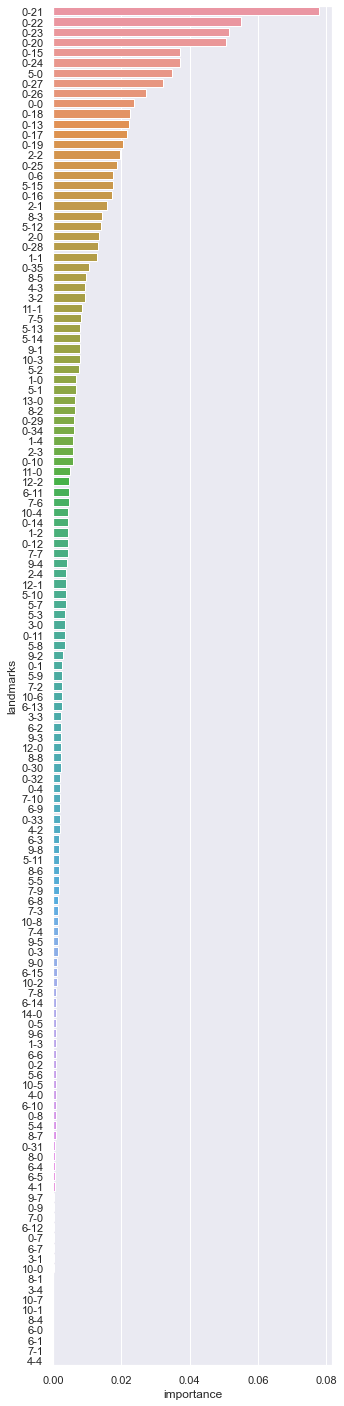

In [7]:
diff_list, landmarks_cut, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'rf')

Index(['0-21', '0-22', '0-23', '0-20', '0-15'], dtype='object')


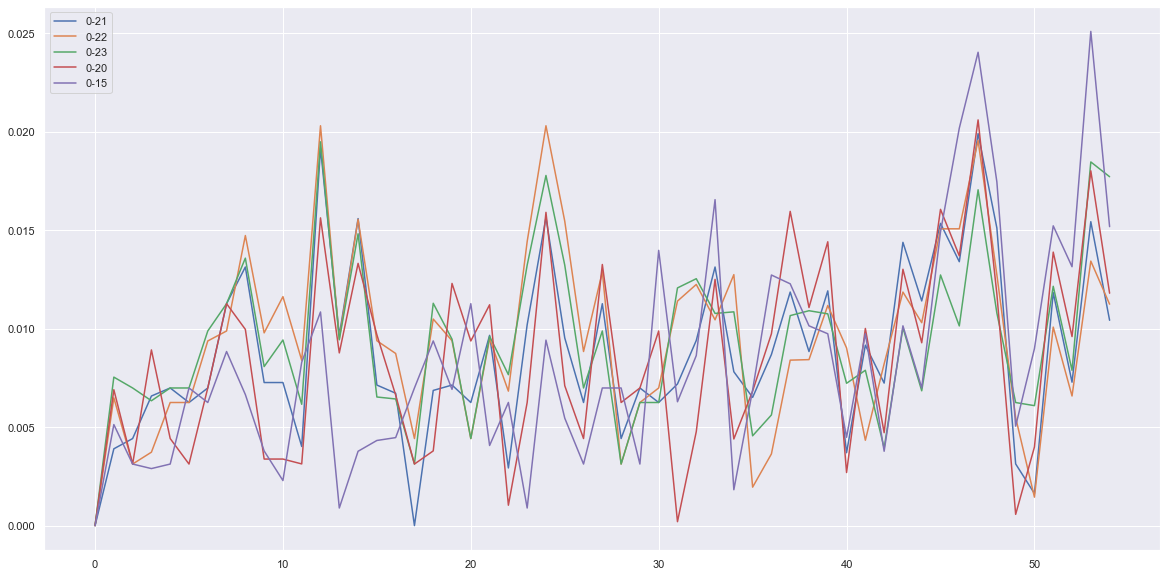

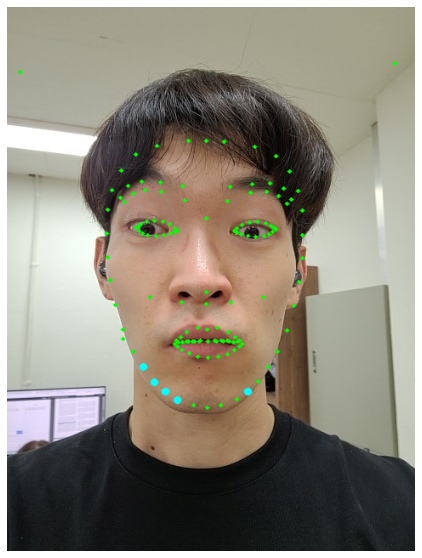

In [8]:
face = '눈썹들어올리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[ 7  4]
 [ 1 10]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.773


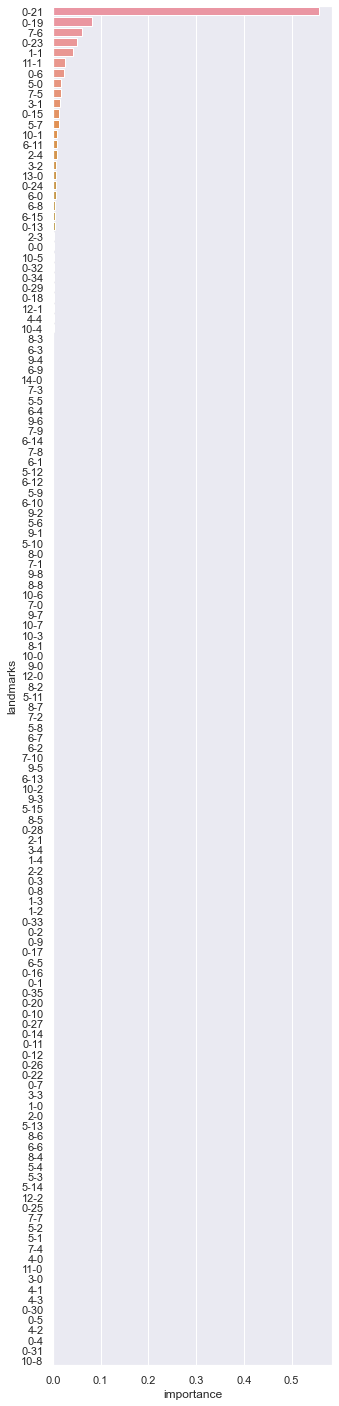

In [9]:
diff_list, landmarks_cut, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'xgboost')

Index(['0-21', '0-19', '7-6', '0-23', '1-1'], dtype='object')


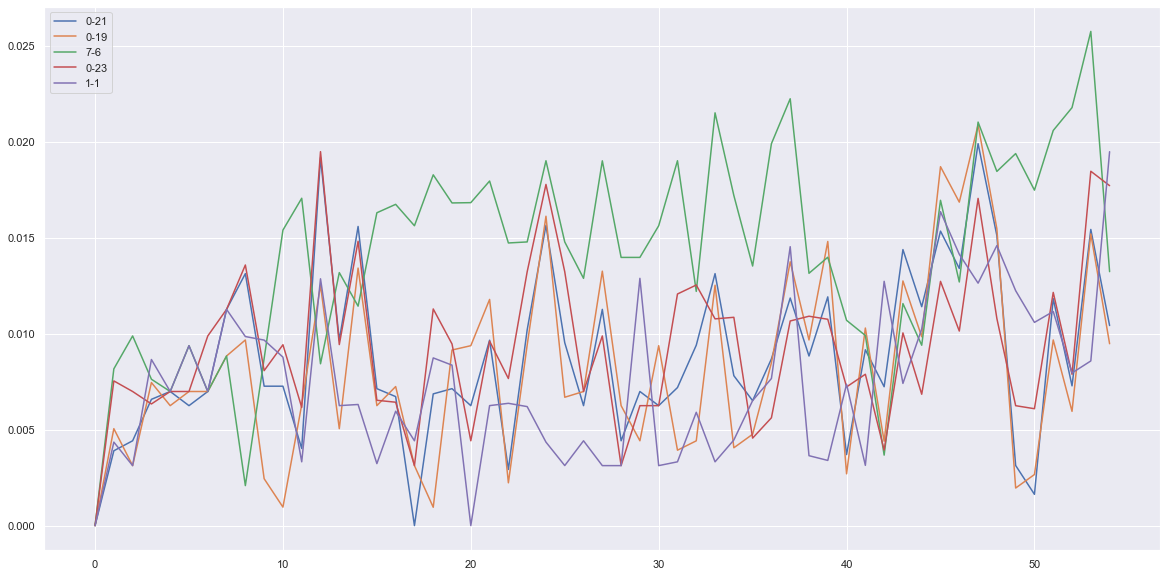

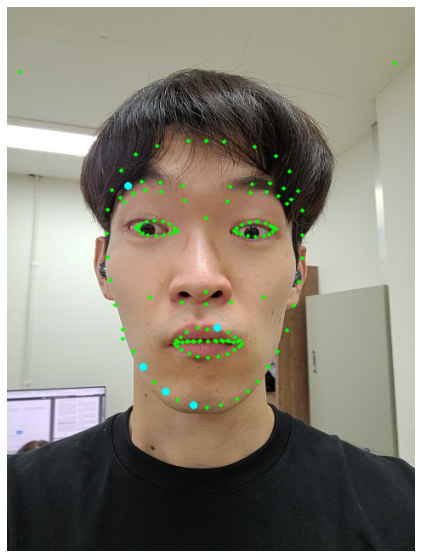

In [10]:
face = '눈썹들어올리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 3. 두 눈 감기

[[13  0]
 [ 3  9]]
훈련세트 정확도: 0.990
테스트세트 정확도: 0.880


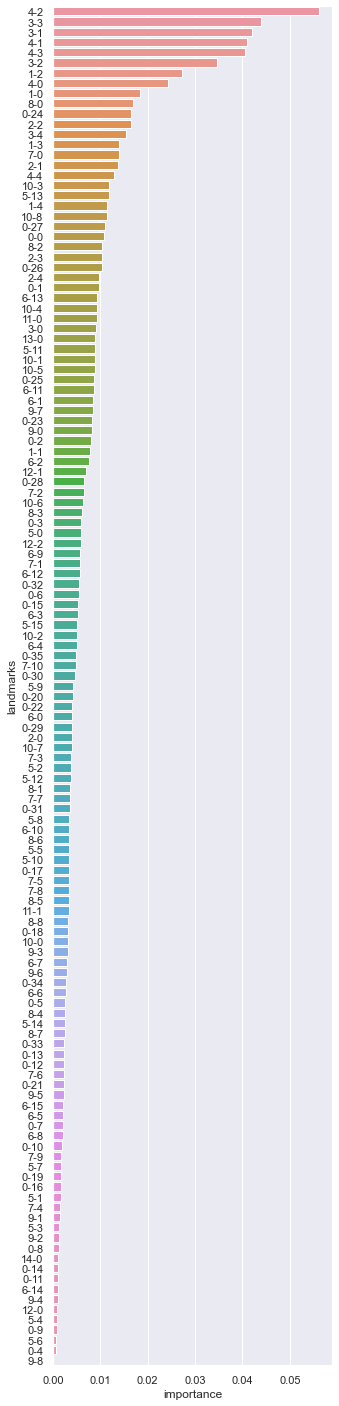

In [11]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'rf')

Index(['4-2', '3-3', '3-1', '4-1', '4-3'], dtype='object')


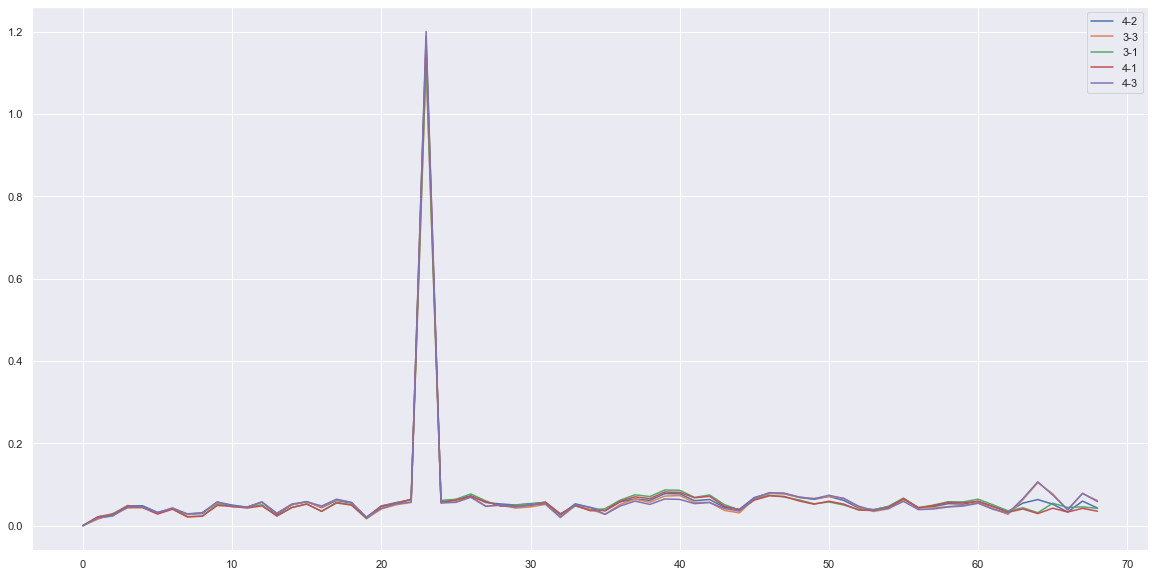

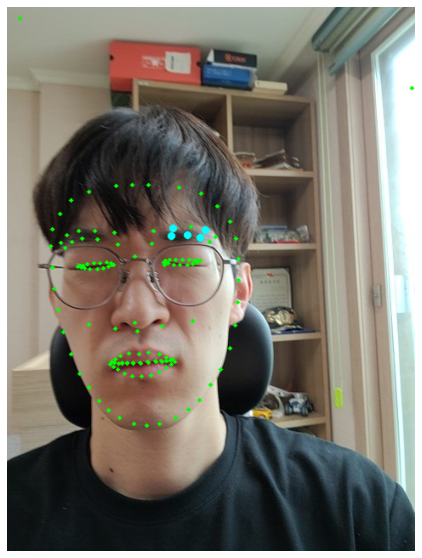

In [12]:
face = '두눈감기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[13  0]
 [ 2 10]]
훈련세트 정확도: 0.990
테스트세트 정확도: 0.920


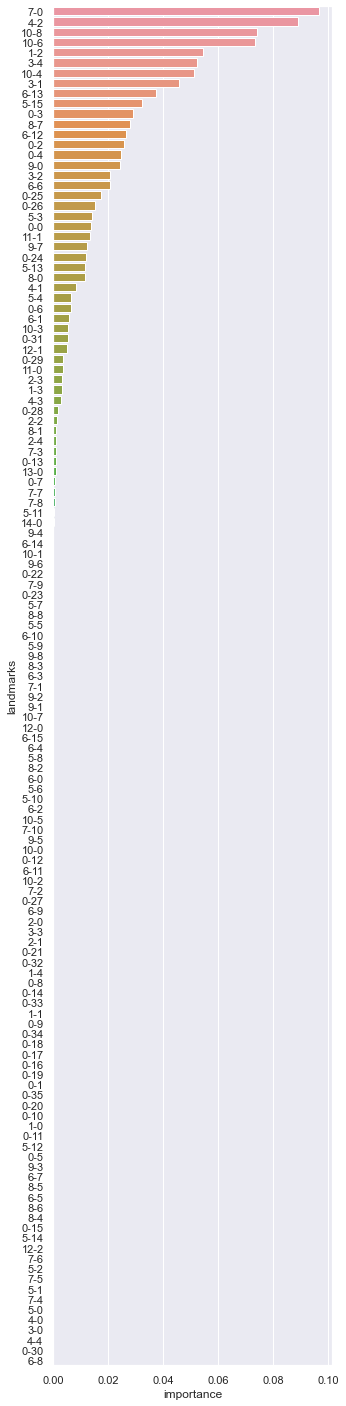

In [13]:
diff_list, landmarks_cut, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'xgboost')

Index(['7-0', '4-2', '10-8', '10-6', '1-2'], dtype='object')


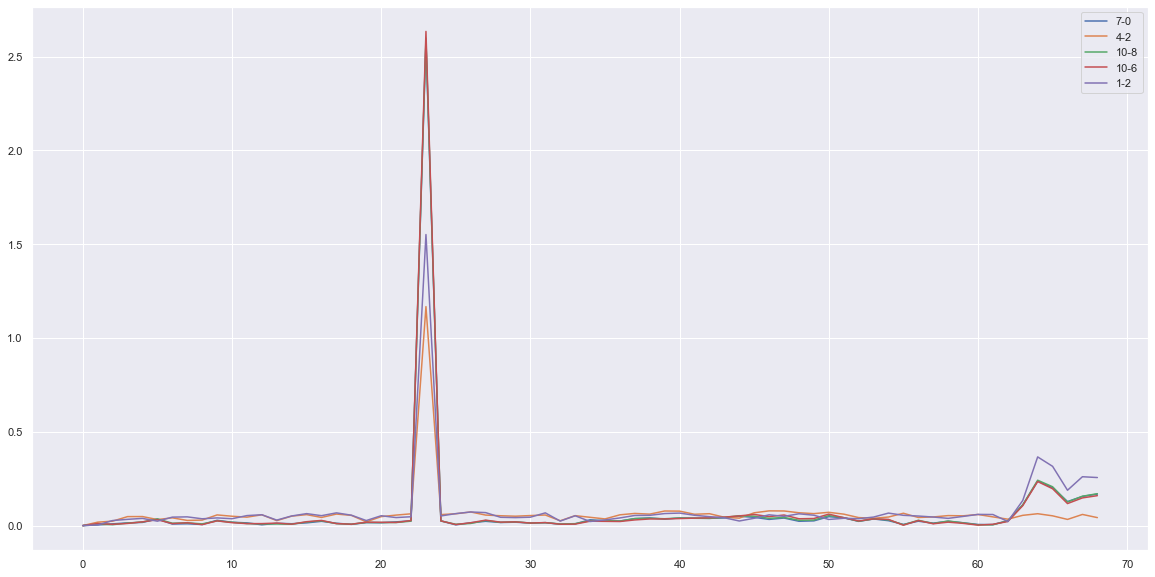

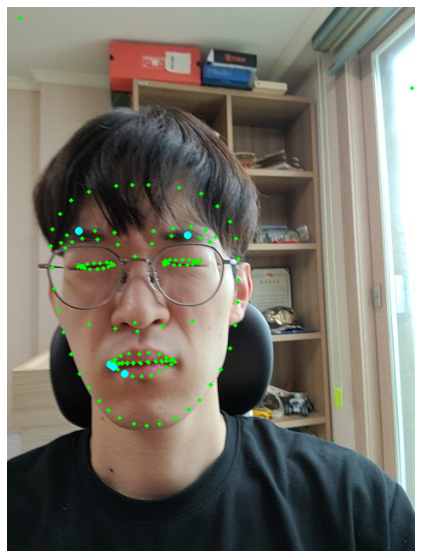

In [14]:
face = '두눈감기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 4. 두 눈 크게 뜨기

[[ 8  6]
 [ 0 13]]
훈련세트 정확도: 0.991
테스트세트 정확도: 0.778


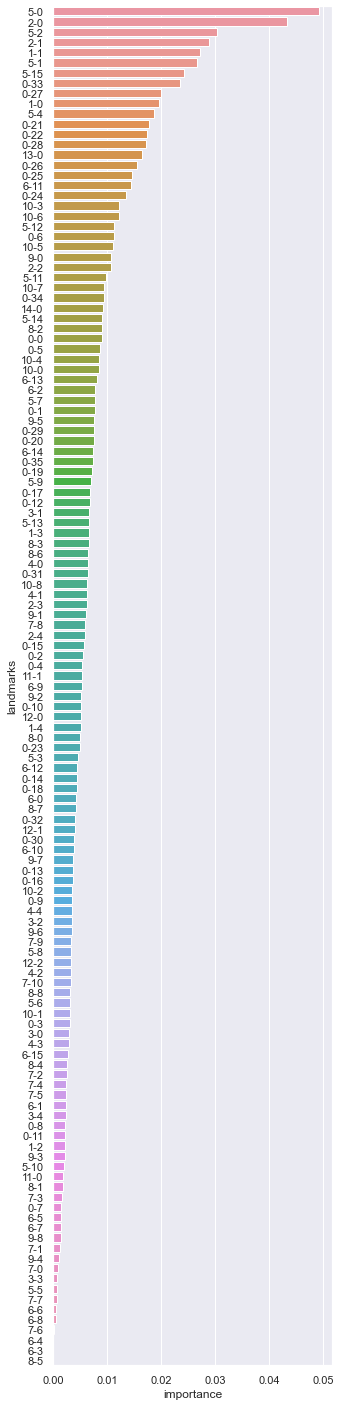

In [15]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'rf')

Index(['5-0', '2-0', '5-2', '2-1', '1-1'], dtype='object')


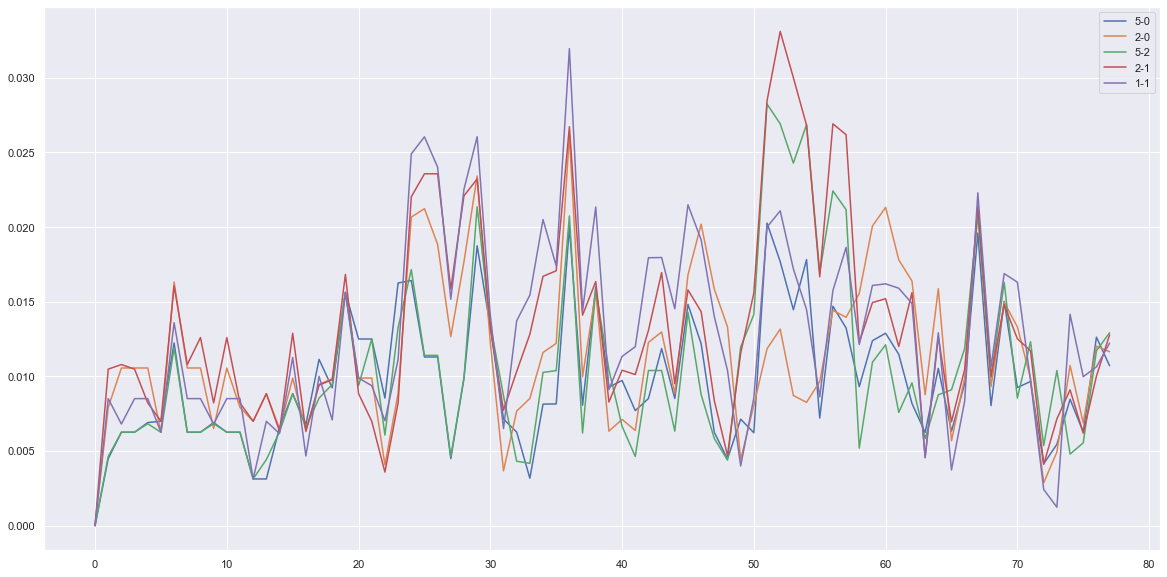

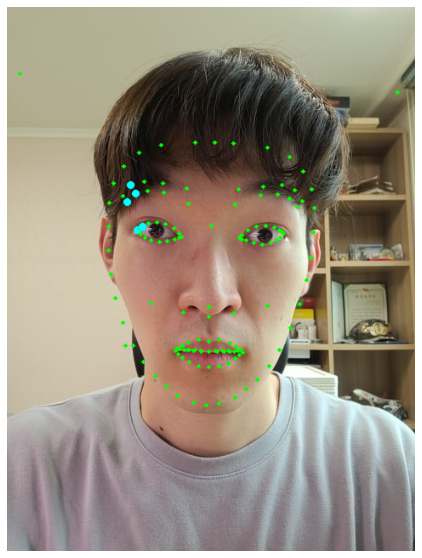

In [16]:
face = '두눈크게뜨기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[10  4]
 [ 0 13]]
훈련세트 정확도: 0.991
테스트세트 정확도: 0.852


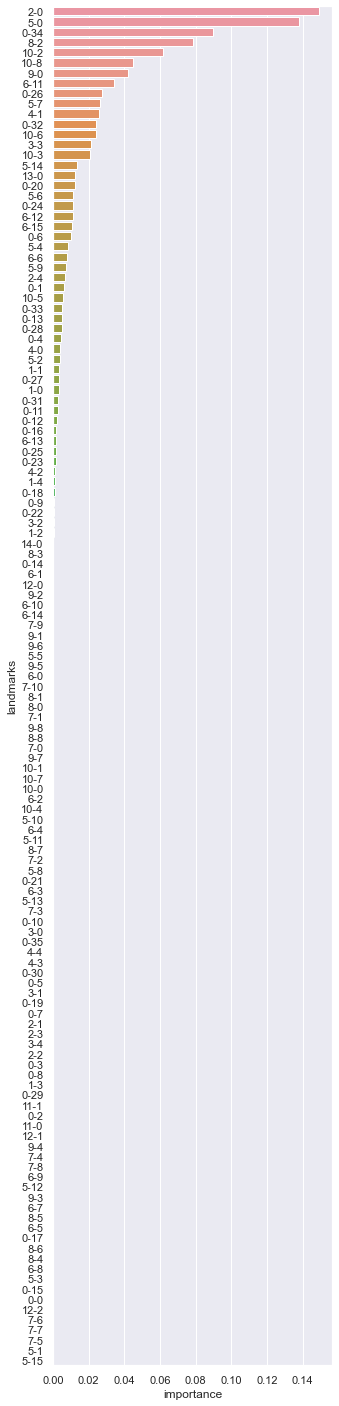

In [17]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'xgboost')

Index(['2-0', '5-0', '0-34', '8-2', '10-2'], dtype='object')


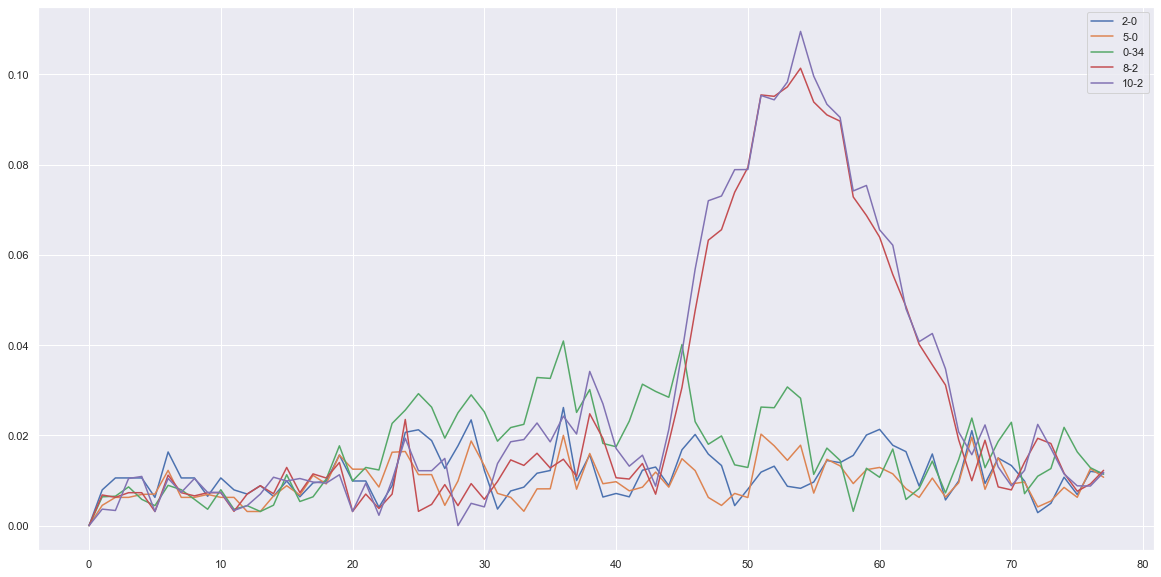

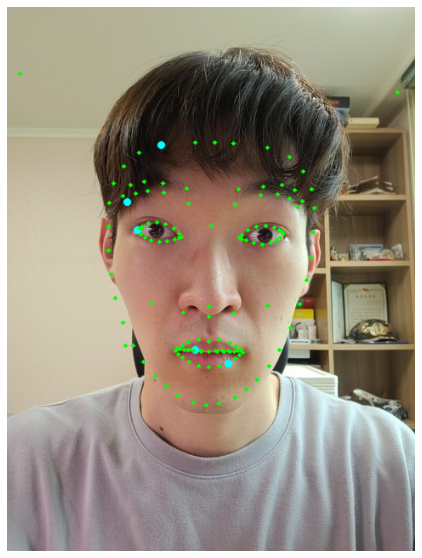

In [18]:
face = '두눈크게뜨기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 9. 입벌리기

[[11  1]
 [ 1 10]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.913


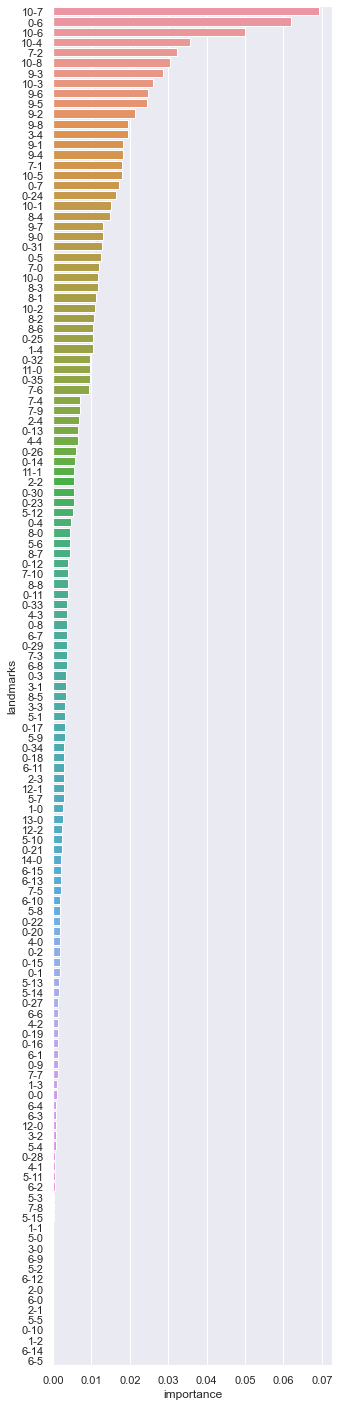

In [19]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'rf')

Index(['10-7', '0-6', '10-6', '10-4', '7-2'], dtype='object')


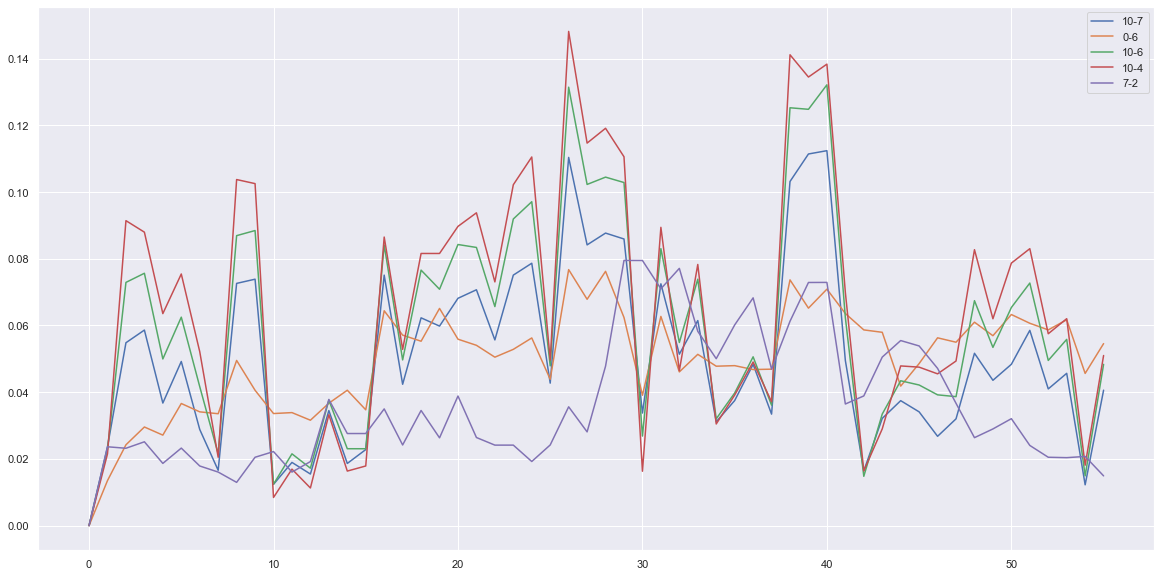

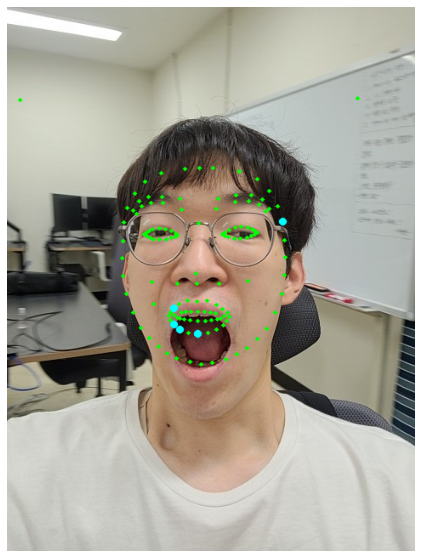

In [20]:
face = '입벌리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[12  0]
 [ 0 11]]
훈련세트 정확도: 0.989
테스트세트 정확도: 1.000


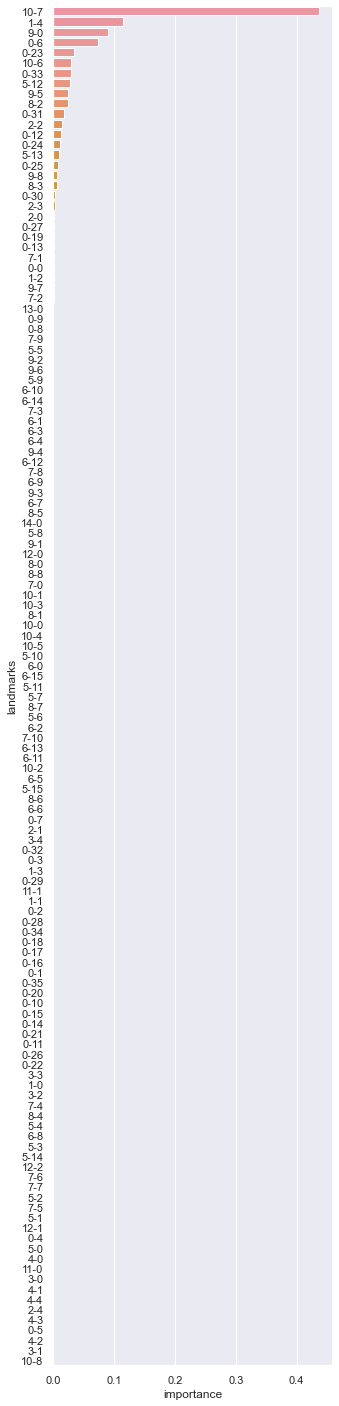

In [21]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'xgboost')

Index(['10-7', '1-4', '9-0', '0-6', '0-23'], dtype='object')


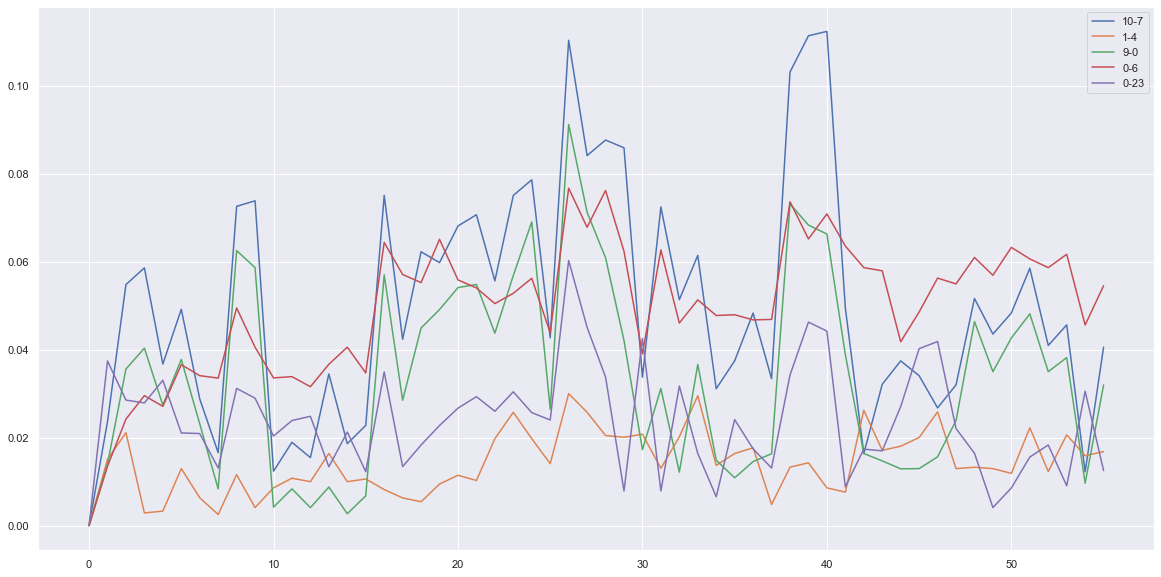

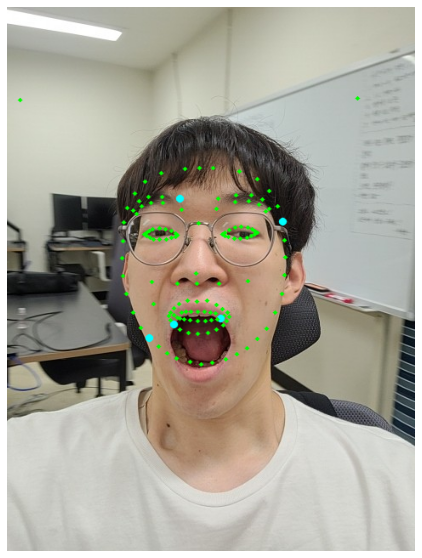

In [22]:
face = '입벌리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 10. 입술 오므리기

[[10  3]
 [ 0 11]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.875


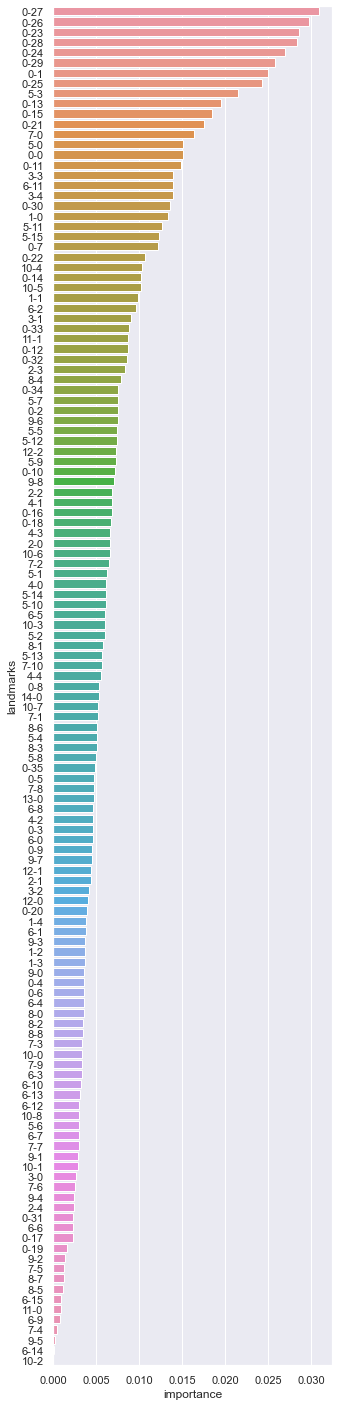

In [26]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.07212003856.csv', 'rf')

Index(['0-27', '0-26', '0-23', '0-28', '0-24'], dtype='object')


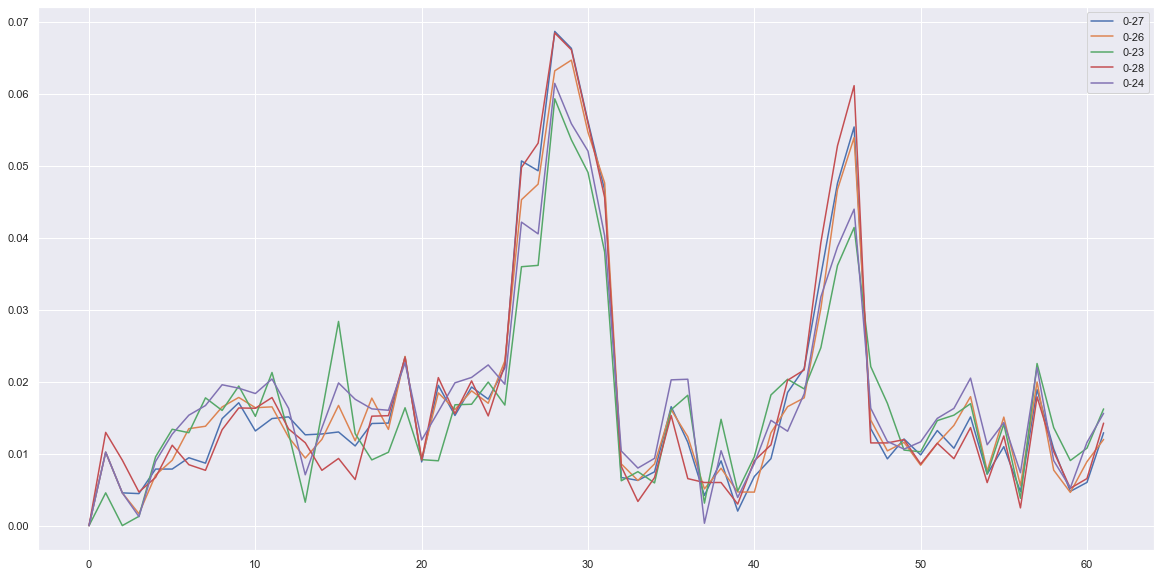

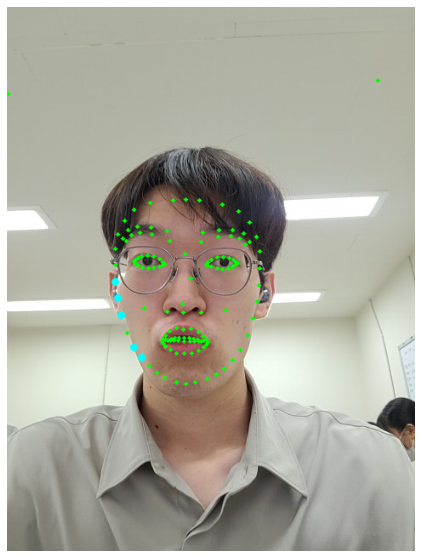

In [29]:
face = '입술오므리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 1,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[12  1]
 [ 1 10]]
훈련세트 정확도: 0.989
테스트세트 정확도: 0.917


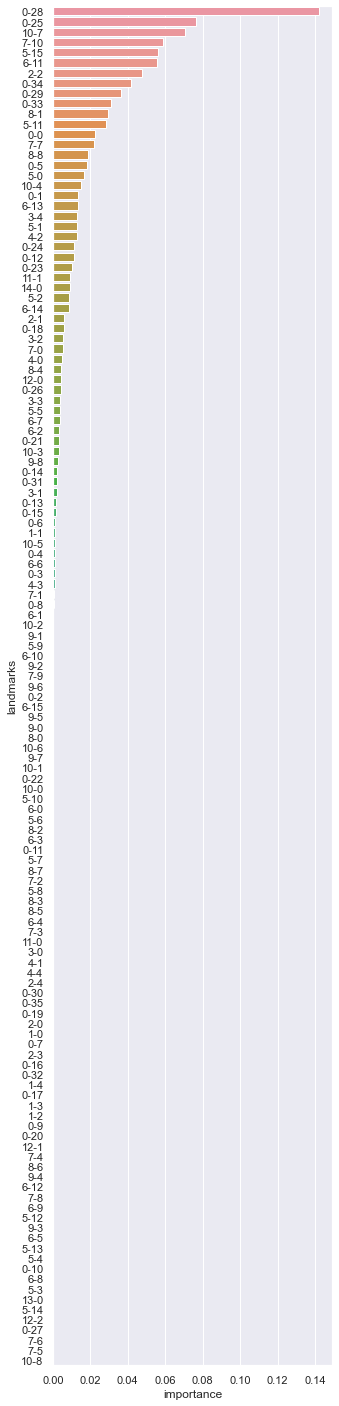

In [30]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.07212003856.csv', 'xgboost')

Index(['0-28', '0-25', '10-7', '7-10', '5-15'], dtype='object')


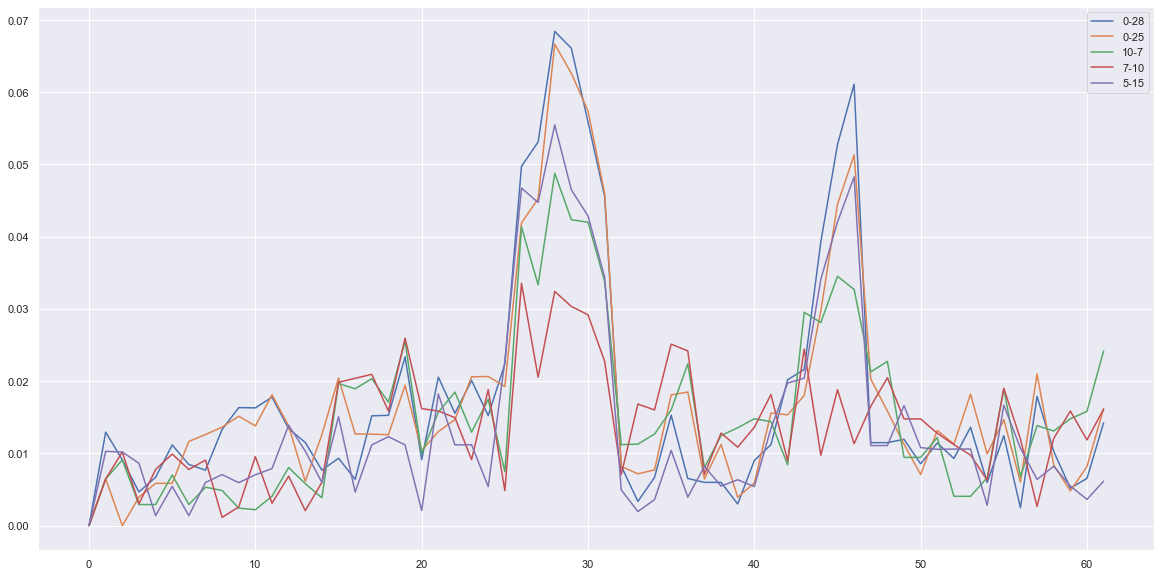

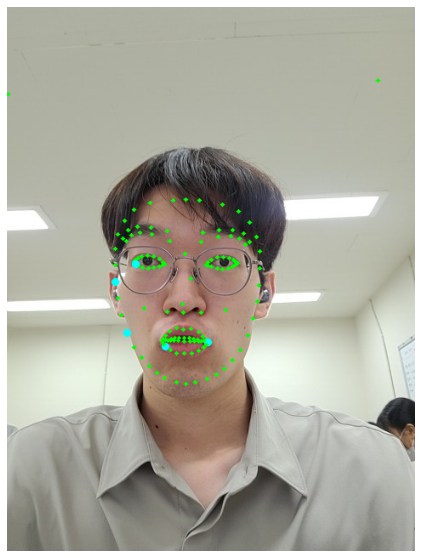

In [32]:
face = '입술오므리기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 1,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

## 16. 미소짓기

[[11  0]
 [ 1  9]]
훈련세트 정확도: 0.988
테스트세트 정확도: 0.952


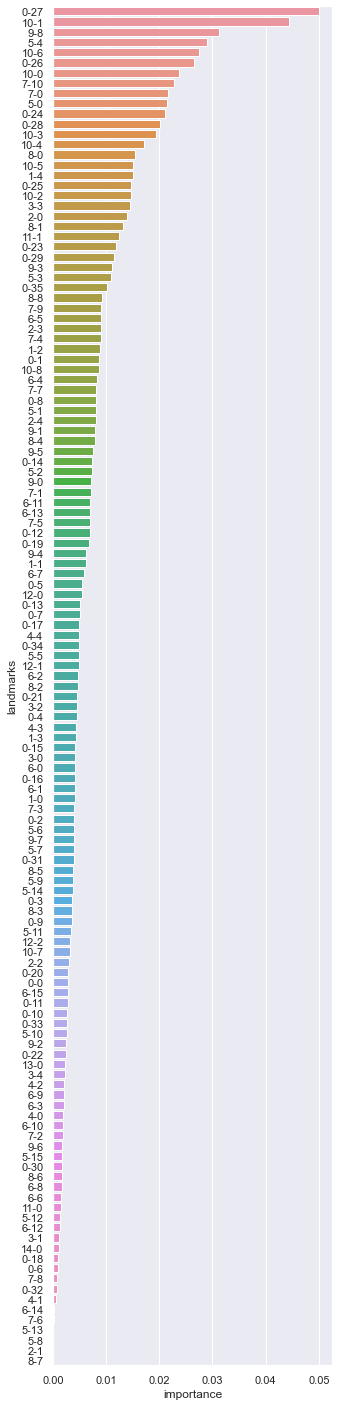

In [33]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'rf')

Index(['0-27', '10-1', '9-8', '5-4', '10-6'], dtype='object')


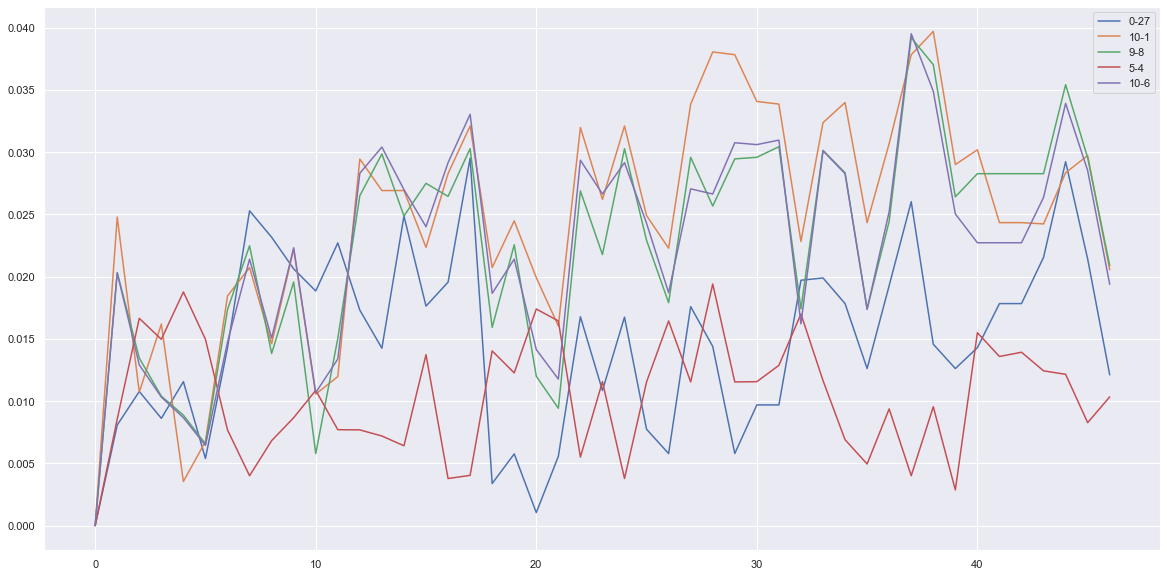

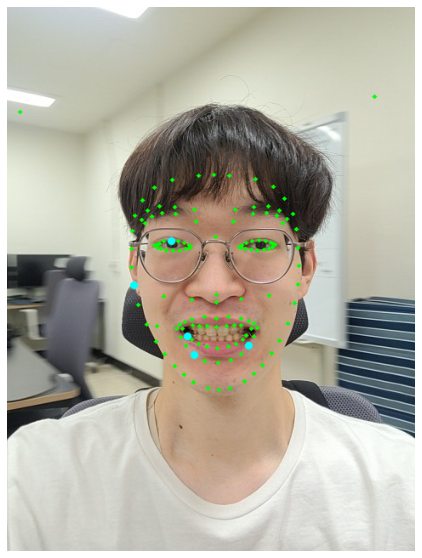

In [34]:
face = '미소짓기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)

[[10  1]
 [ 1  9]]
훈련세트 정확도: 0.988
테스트세트 정확도: 0.905


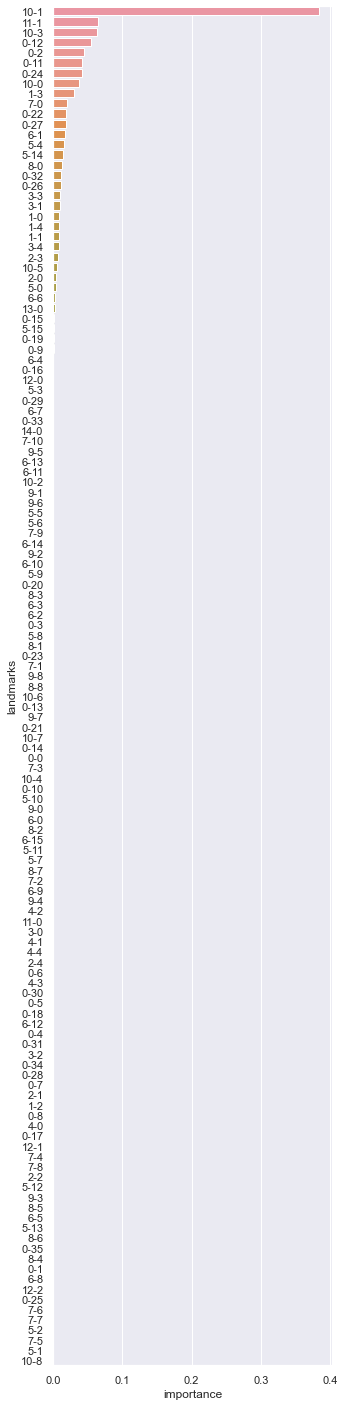

In [35]:
diff_list, landmarks_cut, importance  = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'xgboost')

Index(['10-1', '11-1', '10-3', '0-12', '0-2'], dtype='object')


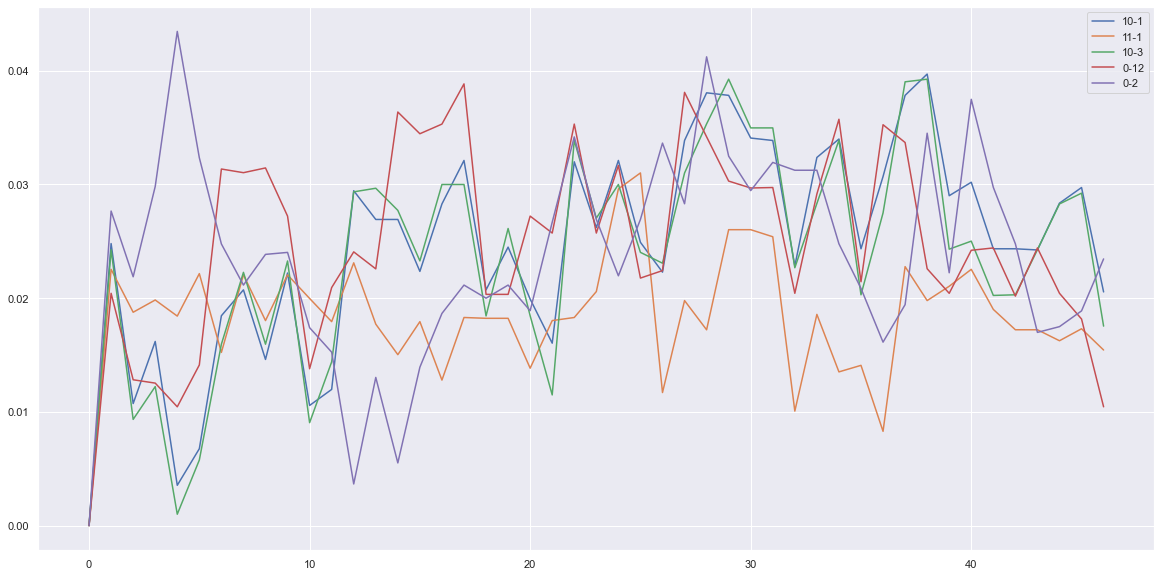

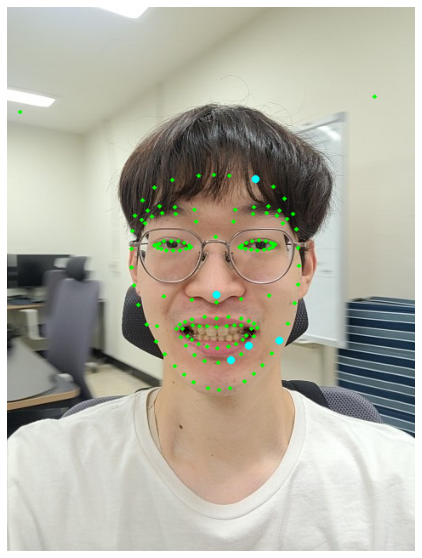

In [36]:
face = '미소짓기+1'
make_flow_chart(part= 1, order = list(importance.landmarks.iloc[:5]), image_order = 15,
                path= '../data/images/'+face+'/',
                data = landmarks_cut, diff_df= diff_list)